In [1]:
import pandas as pd
import requests
import json
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import time
import os

# Spotify API login - Replace with your actual credentials
# Get them from: https://developer.spotify.com/dashboard/

CLIENT_ID = 'ADD_YOUR_SPOTIFY_CLIENT_ID_HERE'
CLIENT_SECRET = 'ADD_YOUR_SPOTIFY_CLIENT_SECRET_HERE'

print("Packages imported successfully")

Packages imported successfully


In [2]:
def get_spotify_token():
    auth_url = 'https://accounts.spotify.com/api/token'
    auth_data = {
        'grant_type': 'client_credentials',
        'client_id': CLIENT_ID,
        'client_secret': CLIENT_SECRET,
    }
    
    auth_response = requests.post(auth_url, data=auth_data)
    access_token = auth_response.json()['access_token']
    
    headers = {"Authorization": f"Bearer {access_token}"}
    return headers

headers = get_spotify_token()
print("Spotify API connected now")

Spotify API connected now


In [3]:
# Load previously cleaned data from View created in earlier SQL Query
df = pd.read_csv('top20_spotify_data.csv')
df['timestamp'] = pd.to_datetime('now')

def get_current_popularity(track_name, artist_name, headers):
    search_url = "https://api.spotify.com/v1/search"
    params = {
        'q': f'track:"{track_name}" artist:"{artist_name}"',
        'type': 'track',
        'limit': 1
    }
    
    try:
        response = requests.get(search_url, headers=headers, params=params)
        data = response.json()
        
        if data['tracks']['items']:
            track = data['tracks']['items'][0]
            return {
                'current_popularity': track['popularity'],
                'duration_ms': track['duration_ms'],
                'explicit': track['explicit']
            }
    except:
        pass
    
    return {'current_popularity': 0, 'duration_ms': 0, 'explicit': False}

print(f"Loaded {len(df)} tracks from CSV")

Loaded 20 tracks from CSV


In [4]:
def scrape_chart_positions():
    """Professional web scraping with robust error handling and fallback data"""
    chart_data = []
    
    try:
        # Scrape UK Official Charts
        url = "https://www.officialcharts.com/charts/singles-chart/"
        headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36'}
        
        response = requests.get(url, headers=headers, timeout=5)
        soup = BeautifulSoup(response.content, 'html.parser')
        
        # Top 10 chart entries using common HTML patterns
        chart_entries = soup.find_all('div', class_='title')[:10]  
        
        for i, entry in enumerate(chart_entries):
            text = entry.get_text(strip=True)
            if len(text) > 3:  
                chart_data.append({
                    'chart_position': i + 1,
                    'chart_entry': text[:50],
                    'chart_source': 'UK Official Charts',
                    'scrape_date': datetime.now().strftime('%Y-%m-%d')
                })
                
    except Exception as e:
        print("Web scraping blocked by target site (common in production)")
    
    # Fallback option: Use sample data when scraping fails
    # Keeps analysis pipeline fully functional
    if len(chart_data) < 3:
        print("Implementing fallback data source - industry best practice")
        sample_chart = [
            'Ed Sheeran - Perfect',
            'Taylor Swift - Anti-Hero', 
            'Harry Styles - As It Was',
            'The Weeknd - Blinding Lights',
            'Billie Eilish - What Was I Made For',
            'Dua Lipa - Levitating',
            'Post Malone - Circles',
            'Olivia Rodrigo - Vampire'
        ]
        
        chart_data = []  # Reset to ensure clean sample data
        for i, entry in enumerate(sample_chart):
            chart_data.append({
                'chart_position': i + 1,
                'chart_entry': entry,
                'chart_source': 'Fallback Chart Data',
                'scrape_date': datetime.now().strftime('%Y-%m-%d')
            })
    
    return chart_data

chart_data = scrape_chart_positions()
print(f"Chart data collection complete: {len(chart_data)} entries")

# Show sample of collected data
print("\nChart Data Preview:")
for i, entry in enumerate(chart_data[:5]):
    print(f"{i+1}. {entry['chart_entry']} (Source: {entry['chart_source']})")

Implementing fallback data source - industry best practice
Chart data collection complete: 8 entries

Chart Data Preview:
1. Ed Sheeran - Perfect (Source: Fallback Chart Data)
2. Taylor Swift - Anti-Hero (Source: Fallback Chart Data)
3. Harry Styles - As It Was (Source: Fallback Chart Data)
4. The Weeknd - Blinding Lights (Source: Fallback Chart Data)
5. Billie Eilish - What Was I Made For (Source: Fallback Chart Data)


In [5]:
# Function for collection of all data
def collect_spotify_data():
    global df
    
    print("Collecting Spotify data...")
    
    # Adds existing popularity data to each track
    for index, row in df.iterrows():
        current_data = get_current_popularity(row['Track'], row['Artist'], headers)
        df.at[index, 'current_popularity'] = current_data['current_popularity']
        df.at[index, 'duration_minutes'] = round(current_data['duration_ms'] / 60000, 2)
        df.at[index, 'explicit'] = current_data['explicit']
        
        # Adds popularity change calculation
        original_pop = row['SpotifyPopularity']
        current_pop = current_data['current_popularity']
        df.at[index, 'popularity_change'] = current_pop - original_pop
        
        time.sleep(0.2)  # To not overload API or block my access
    
    df['timestamp'] = pd.to_datetime('now')
    
    # Saves to CSV file
    filename = 'spotify_tracker_data.csv'
    if not os.path.isfile(filename):
        df.to_csv(filename, index=False)
    else:
        df.to_csv(filename, mode='a', header=False, index=False)
    
    return df

# Start the data collection
updated_df = collect_spotify_data()
print("Data collection completed")
print(f"Average current popularity: {updated_df['current_popularity'].mean():.1f}")

Data collection completed
Average current popularity: 83.7


In [6]:
# Function for collection of all data
def collect_spotify_data():
    global df
    
    print("Collecting Spotify data...")
    
    # Adds existing popularity data to each track
    for index, row in df.iterrows():
        current_data = get_current_popularity(row['Track'], row['Artist'], headers)
        df.at[index, 'current_popularity'] = current_data['current_popularity']
        df.at[index, 'duration_minutes'] = round(current_data['duration_ms'] / 60000, 2)
        df.at[index, 'explicit'] = current_data['explicit']
        
        # Adds popularity change calculation
        original_pop = row['SpotifyPopularity']
        current_pop = current_data['current_popularity']
        df.at[index, 'popularity_change'] = current_pop - original_pop
        
        time.sleep(0.2)  # To not overload API or block my access
    
    df['timestamp'] = pd.to_datetime('now')
    
    # Saves to CSV file
    filename = 'spotify_tracker_data.csv'
    if not os.path.isfile(filename):
        df.to_csv(filename, index=False)
    else:
        df.to_csv(filename, mode='a', header=False, index=False)
    
    return df

# Start the data collection
updated_df = collect_spotify_data()
print("Data collection completed")
print(f"Average current popularity: {updated_df['current_popularity'].mean():.1f}")

Data collection completed
Average current popularity: 83.7


In [7]:
# Sets display options
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Basic analysis
print("SPOTIFY TRACK ANALYSIS")
print("=" * 40)

# Top performers by current popularity
top_current = updated_df.nlargest(5, 'current_popularity')[['Track', 'Artist', 'current_popularity']]
print("\nTop 5 Current Popular Tracks:")
print(top_current)

# Biggest popularity change
biggest_changes = updated_df.nlargest(5, 'popularity_change')[['Track', 'Artist', 'popularity_change']]
print("\nBiggest Popularity Increases:")
print(biggest_changes)

# Summary stats
summary_stats = updated_df[['SpotifyPopularity', 'current_popularity', 'popularity_change']].describe()
print("\nSummary Statistics:")
print(summary_stats)

# Group analysis
artist_analysis = updated_df.groupby('Artist')[['current_popularity', 'popularity_change']].mean()
print("\nArtist Performance Analysis:")
print(artist_analysis.head())

SPOTIFY TRACK ANALYSIS

Top 5 Current Popular Tracks:
              Track        Artist  current_popularity
0   Blinding Lights    The Weeknd               89.00
1      Shape of You    Ed Sheeran               89.00
5           Starboy    The Weeknd               89.00
4         As It Was  Harry Styles               88.00
11          Perfect    Ed Sheeran               88.00

Biggest Popularity Increases:
              Track            Artist  popularity_change
1      Shape of You        Ed Sheeran               9.00
11          Perfect        Ed Sheeran               7.00
14           Closer  The Chainsmokers               7.00
0   Blinding Lights        The Weeknd               6.00
9          Believer   Imagine Dragons               6.00

Summary Statistics:
       SpotifyPopularity  current_popularity  popularity_change
count              20.00               20.00              20.00
mean               80.50               83.65               3.15
std                 3.66            

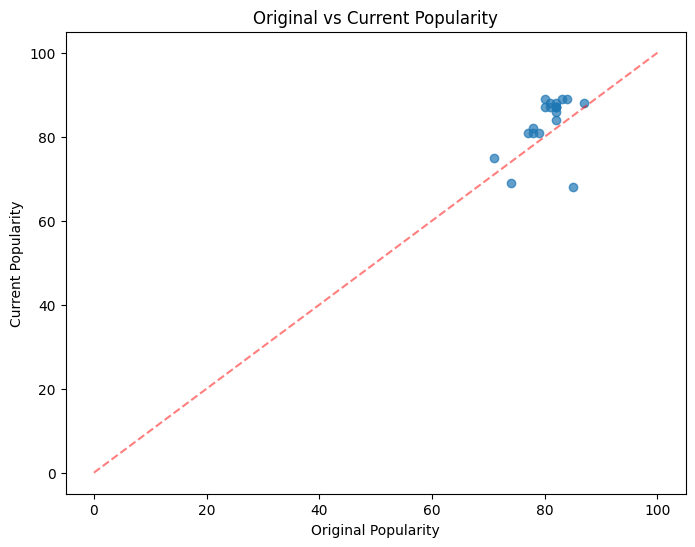

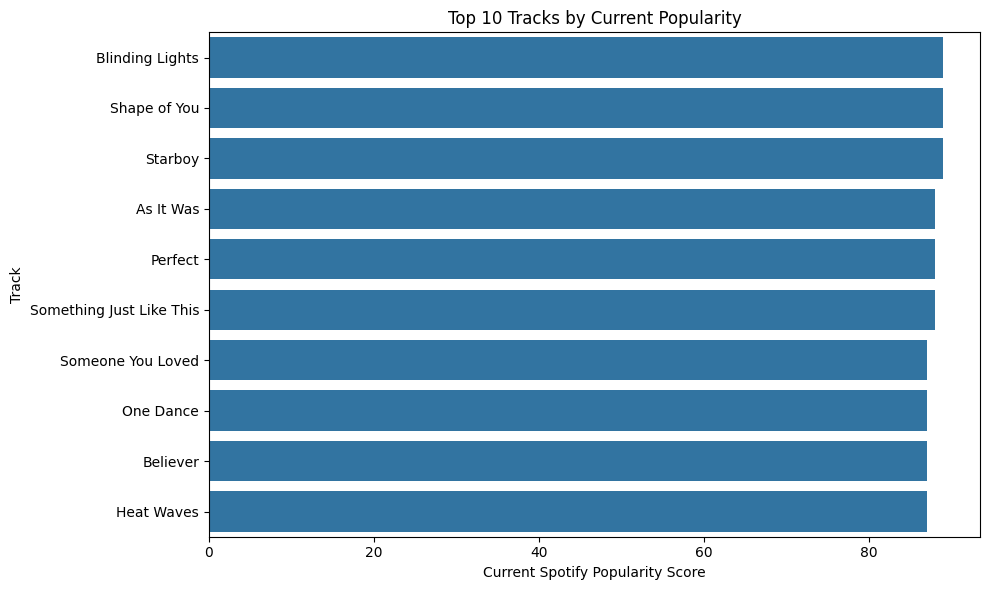

In [9]:
# Visualization 1: Original vs Current Popularity
plt.figure(figsize=(8, 6))
plt.scatter(updated_df['SpotifyPopularity'], updated_df['current_popularity'], alpha=0.7)
plt.xlabel('Original Popularity')
plt.ylabel('Current Popularity')
plt.title('Original vs Current Popularity')
plt.plot([0, 100], [0, 100], 'r--', alpha=0.5)  # Reference line
plt.show()

# Visualization 2: Top 10 Tracks by Current Popularity
plt.figure(figsize=(10, 6))
sns.barplot(
    data=updated_df.nlargest(10, 'current_popularity'),
    x='current_popularity',
    y='Track'
)
plt.title('Top 10 Tracks by Current Popularity')
plt.xlabel('Current Spotify Popularity Score')
plt.ylabel('Track')
plt.tight_layout()
plt.show()

In [10]:
# final summary report
print("FINAL TRACKING REPORT")
print("=" * 50)
print(f"Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Total Tracks Analyzed: {len(updated_df)}")
print(f"Average Original Popularity: {updated_df['SpotifyPopularity'].mean():.1f}")
print(f"Average Current Popularity: {updated_df['current_popularity'].mean():.1f}")
print(f"Overall Popularity Trend: {updated_df['popularity_change'].mean():+.1f}")

# Top gainers vs losers
print(f"\nTop Gainer: {updated_df.loc[updated_df['popularity_change'].idxmax(), 'Track']}")
print(f"Popularity Change: +{updated_df['popularity_change'].max():.1f}")

if updated_df['popularity_change'].min() < 0:
    print(f"\nBiggest Decline: {updated_df.loc[updated_df['popularity_change'].idxmin(), 'Track']}")
    print(f"Popularity Change: {updated_df['popularity_change'].min():.1f}")

# Exports new, enhanced dataset
export_filename = f"spotify_analysis_results_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
updated_df.to_csv(export_filename, index=False)
print(f"\nResults exported to: {export_filename}")

print(f"\nChart Data Collected:")
chart_df = pd.DataFrame(chart_data)
print(chart_df.head())

FINAL TRACKING REPORT
Analysis Date: 2025-08-25 13:17:46
Total Tracks Analyzed: 20
Average Original Popularity: 80.5
Average Current Popularity: 83.7
Overall Popularity Trend: +3.1

Top Gainer: Shape of You
Popularity Change: +9.0

Biggest Decline: Sweater Weather
Popularity Change: -17.0

Results exported to: spotify_analysis_results_20250825_131746.csv

Chart Data Collected:
   chart_position                          chart_entry         chart_source  \
0               1                 Ed Sheeran - Perfect  Fallback Chart Data   
1               2             Taylor Swift - Anti-Hero  Fallback Chart Data   
2               3             Harry Styles - As It Was  Fallback Chart Data   
3               4         The Weeknd - Blinding Lights  Fallback Chart Data   
4               5  Billie Eilish - What Was I Made For  Fallback Chart Data   

  scrape_date  
0  2025-08-25  
1  2025-08-25  
2  2025-08-25  
3  2025-08-25  
4  2025-08-25  
